In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.cm as cm
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

client = Client(n_workers=10, threads_per_worker=1, memory_limit='20GB')

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 186.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40271,Workers: 10
Dashboard: /user/a270088/levante-spawner-preset//proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 186.26 GiB
Comm: tcp://127.0.0.1:41473,Total threads: 1
Dashboard: /user/a270088/levante-spawner-preset//proxy/38475/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:46525,


## Open interpolated data for IFS 2t

In [4]:
data_path = "/work/ab0995/a270088/NextGems_public/appetizer/IFS2.5/2t/netcdf/"

### Fast version, if you have index

In [5]:
data = xr.open_zarr("reference::/work/ab0995/a270088/NextGems_public/appetizer/IFS2.5/2t/netcdf/tco3999-ng5_pc_2t.json", consolidated=False)

In [6]:
data

<xarray.Dataset>
Dimensions:    (time: 985, lat: 2700, lon: 5400)
Coordinates:
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
    latitude   (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    longitude  (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
  * time       (time) datetime64[ns] 2020-01-20 ... 2020-03-01
Data variables:
    2t         (time, lat, lon) float32 dask.array<chunksize=(1, 1350, 2700), meta=np.ndarray>
Attributes:
    experiment_id:  tco3999-ng5
    interpolation:  nearest neighbour

### Slow version, if index is not available

In [4]:
data = xr.open_mfdataset('/work/ab0995/a270088/NextGems_public/appetizer/IFS2.5/2t/netcdf/tco3999-ng5_pc_2t_*.nc', 
                         decode_cf=False,
                         combine='nested',
                         concat_dim ='time', 
                         chunks={'time':1}
                        )

In [5]:
time = pd.date_range('2020-01-20 00:00', '2020-03-01 00:00', freq='H')

In [6]:
data = data.assign_coords({'time':time})

In [7]:
data

<xarray.Dataset>
Dimensions:    (time: 985, lat: 2700, lon: 5400)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-20 ... 2020-03-01
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
Data variables:
    2t         (time, lat, lon) float32 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
    longitude  (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
    latitude   (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
Attributes:
    experiment_id:  tco3999-ng5
    interpolation:  nearest neighbour

## Looking at the data

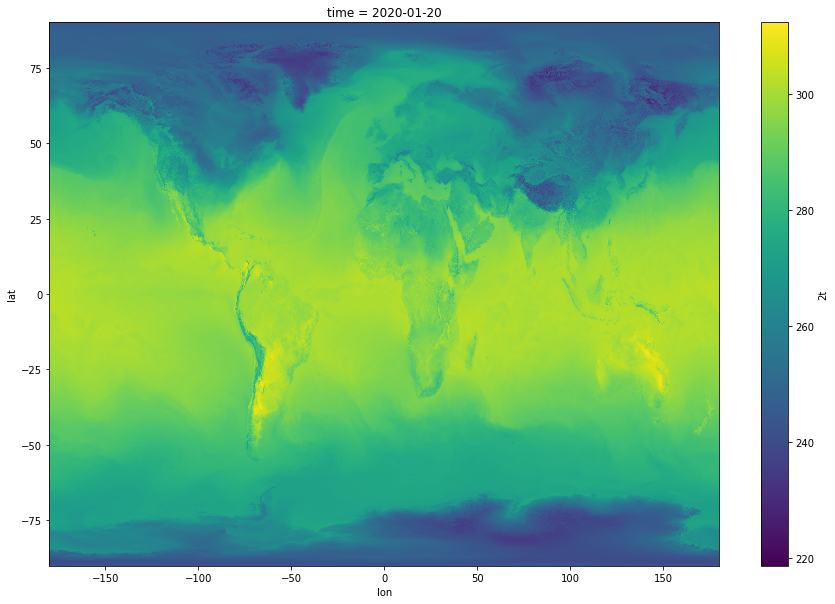

In [7]:
data['2t'][0,:,:].plot(figsize=(15,10))

(-0.5, 5399.5, 2699.5, -0.5)

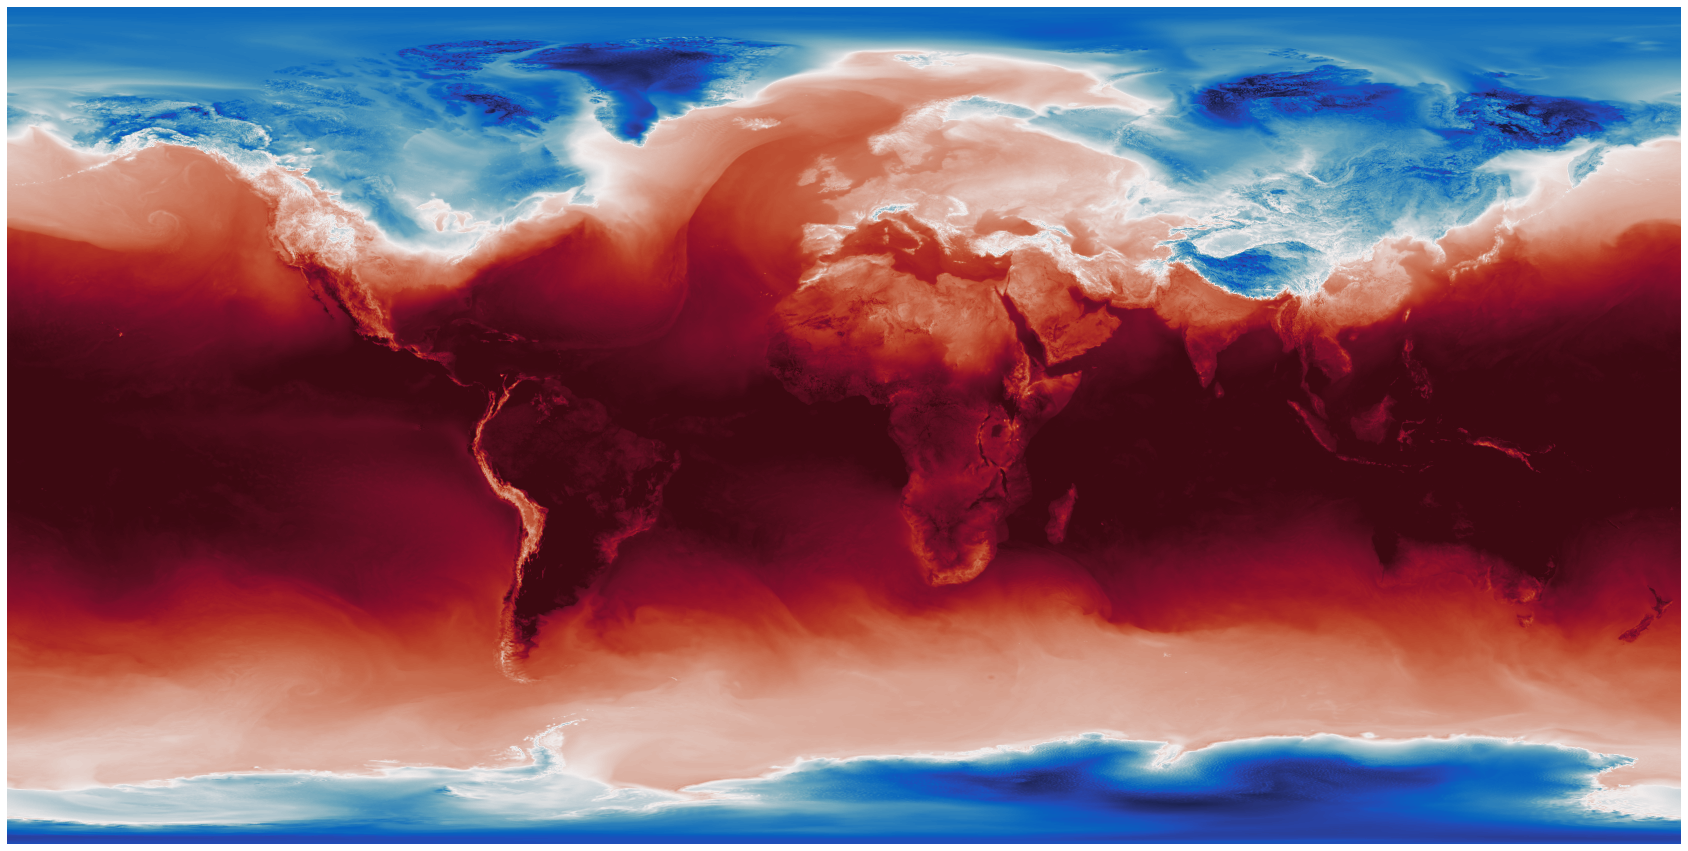

In [10]:
plt.figure(figsize=(30,30))
plt.imshow(np.flipud(data['2t'][0,:,:].values), cmap=cmo.balance, vmin=233, vmax=300)
plt.axis('off')

## Compute mean for February 

In [11]:
data.sel(time='2020-02')

<xarray.Dataset>
Dimensions:    (time: 696, lat: 2700, lon: 5400)
Coordinates:
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
    latitude   (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    longitude  (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
  * time       (time) datetime64[ns] 2020-02-01 ... 2020-02-29T23:00:00
Data variables:
    2t         (time, lat, lon) float32 dask.array<chunksize=(1, 1350, 2700), meta=np.ndarray>
Attributes:
    experiment_id:  tco3999-ng5
    interpolation:  nearest neighbour

In [12]:
time_mean = data.sel(time='2020-02').mean(dim='time').compute()

In [13]:
time_mean

<xarray.Dataset>
Dimensions:  (lat: 2700, lon: 5400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    2t       (lat, lon) float32 235.0 235.0 235.0 235.0 ... 244.3 244.3 244.3

(-0.5, 5399.5, 2699.5, -0.5)

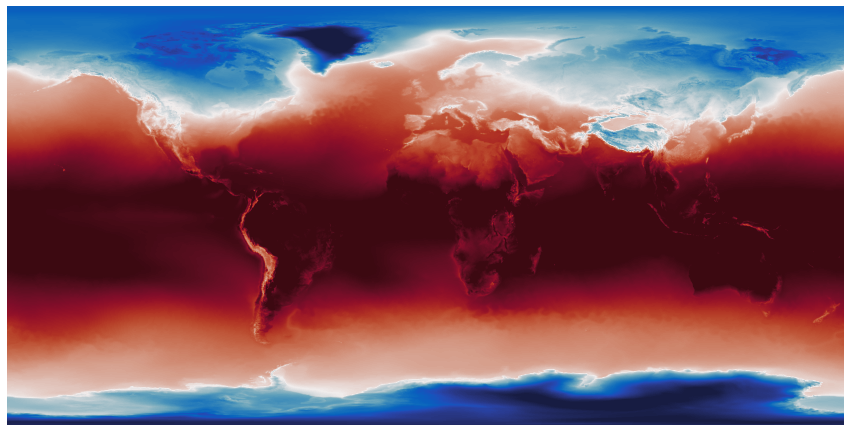

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(time_mean['2t'][:,:].values), cmap=cmo.balance, vmin=233, vmax=300)
plt.axis('off')

In [18]:
time_mean['2t']

<xarray.DataArray '2t' (lat: 2700, lon: 5400)>
array([[235.00467, 234.95775, 234.95775, ..., 235.00467, 235.00467,
        235.00467],
       [234.82687, 234.82687, 234.82687, ..., 234.8729 , 234.8729 ,
        234.8729 ],
       [234.88602, 234.88602, 234.88602, ..., 234.94621, 234.94621,
        234.88602],
       ...,
       [244.29575, 244.29575, 244.29575, ..., 244.3005 , 244.3005 ,
        244.3005 ],
       [244.30559, 244.30559, 244.30559, ..., 244.31311, 244.31311,
        244.31311],
       [244.31232, 244.31232, 244.31232, ..., 244.31232, 244.31232,
        244.31232]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0

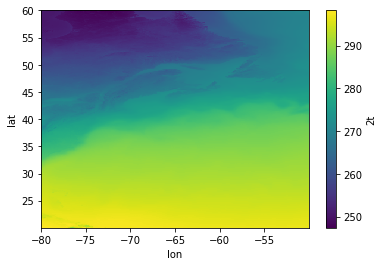

In [20]:
time_mean['2t'].sel(lon=slice(-80, -50), lat=slice(20, 60)).plot()

In [27]:
data_cut = time_mean['2t'].sel(lon=slice(-80, -50), lat=slice(20, 60))

In [ ]:
time_mean.lon

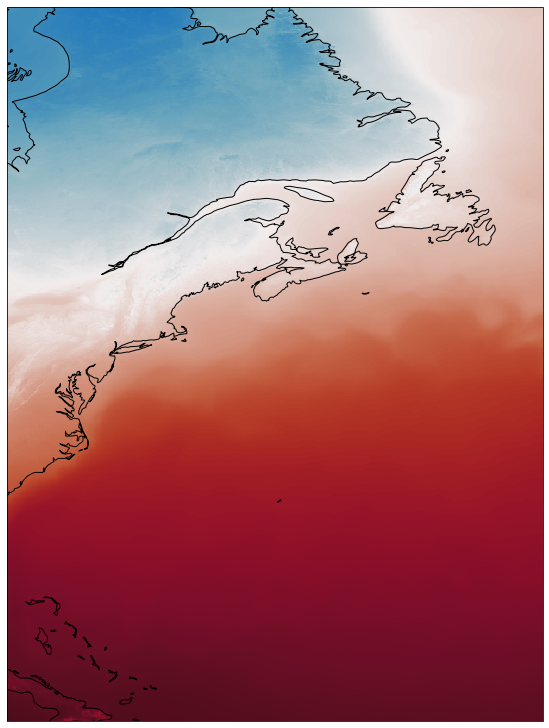

In [32]:
fig, ax = plt.subplots(
    1,1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    constrained_layout=True,
    figsize=(15,10),
)
ax.set_extent([-80, -50, 20, 60], crs=ccrs.PlateCarree())
image = ax.pcolormesh(
                data_cut.lon,
                data_cut.lat,
                data_cut.values,
                vmin=233,
                vmax=300,
                transform=ccrs.PlateCarree(),
                cmap=cmo.balance,
            )
ax.coastlines('50m')